In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

import anomaly_detection as ao

sns.set()

In [3]:
def run_anomalies(df, run_date, social_mod=None,
                  limit=95, horizon=12, simulations=10):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations,
                                   social_mod=social_mod)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


# Figure 1: Panel E and F

In [4]:
# Create the Brooklyn, NY and Miami, FL ensemble forecasting and anomaly detection example
# for Figure 1 Subplots
bk_df = pd.read_csv('data/brooklyn.csv')
bk_df['ds'] = pd.to_datetime(bk_df['ds'])

md_df = pd.read_csv('data/miami_dade.csv')
md_df['ds'] = pd.to_datetime(md_df['ds'])
md_df['doy'] = md_df.ds.dt.dayofyear

sc_df = pd.read_csv('data/santa_clara.csv')
sc_df['ds'] = pd.to_datetime(sc_df['ds'])

In [5]:
bk100 = run_anomalies(bk_df, ['2020-03-01'], simulations=100)
md100 = run_anomalies(md_df, ['2020-03-01'], simulations=100)
sc100 = run_anomalies(sc_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Forecasting for 12086
Forecasting for 6085


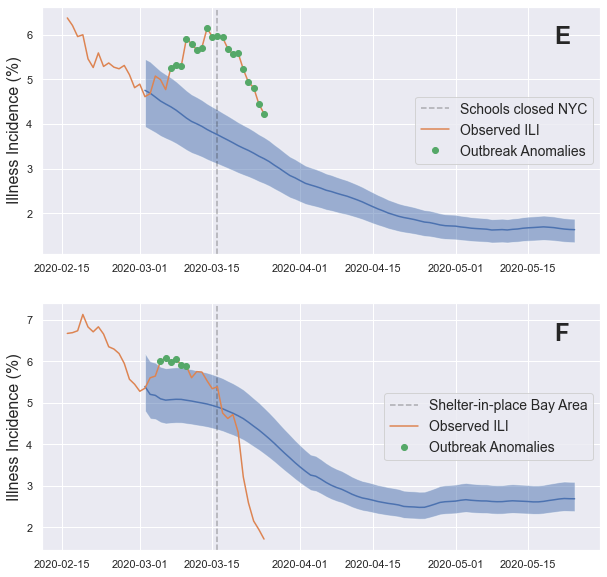

In [6]:
sub_bk = bk100[bk100.ds > '2020-02-15'].copy()
sub_bk.sort_values('ds', inplace=True)

sub_md = md100[md100.ds > '2020-02-15'].copy()
sub_md.sort_values('ds', inplace=True)

sub_md = sc100[sc100.ds > '2020-02-15'].copy()
sub_md.sort_values('ds', inplace=True)

# Figure 1: subplots A and B
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Panel A: Brookly, NY Anomaly Detection
ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[0].fill_between(sub_bk.ds, sub_bk['97.5%'], sub_bk['2.5%'], alpha=0.5)
ax[0].plot(sub_bk.ds, sub_bk['50%'], label='')
ax[0].plot(sub_bk.ds, sub_bk.percent_ill, label='Observed ILI')
ax[0].plot(sub_bk.ds, sub_bk.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

# Panel b: Miami Dade, FL Anomaly Detection
ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sub_md.ds, sub_md['97.5%'], sub_md['2.5%'], alpha=0.5)
ax[1].plot(sub_md.ds, sub_md['50%'], label='')
ax[1].plot(sub_md.ds, sub_md.percent_ill, label='Observed ILI')
ax[1].plot(sub_md.ds, sub_md.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=14, loc='center right')
ax[1].legend(fontsize=14, loc='center right')
ax[0].text(pd.to_datetime('2020-05-20'), 5.8, 'E', fontsize=24, fontweight='bold')
ax[1].text(pd.to_datetime('2020-05-20'), 6.5, 'F', fontsize=24, fontweight='bold')
plt.savefig('Fig1EF.png', dpi=300)

## Figure 2: Panels A, B, C

In [7]:
# Figure 2: Impact of social distancing on three major counties (BK, SC, MIA)
# Distancing reductions of 25% influenza transmission
bk_distancing = run_anomalies(bk_df, ['2020-03-01'], social_mod=0.75, simulations=100)
md_distancing = run_anomalies(md_df, ['2020-03-01'], social_mod=0.75, simulations=100)
sc_distancing = run_anomalies(sc_df, ['2020-03-01'], social_mod=0.75, simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Forecasting for 12086
Forecasting for 6085


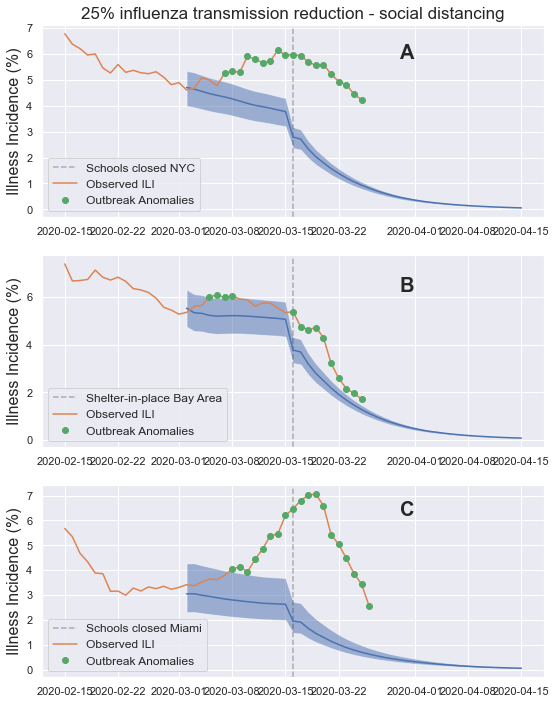

In [8]:
### Social distancing estimate in Brooklyn

bk_75 = bk_distancing[(bk_distancing.ds >= '2020-02-15') &
                      (bk_distancing.ds <= '2020-04-15')].copy()
bk_75.sort_values('ds', inplace=True)

md_75 = md_distancing[(md_distancing.ds >= '2020-02-15') &
                      (md_distancing.ds <= '2020-04-15')].copy()
md_75.sort_values('ds', inplace=True)

sc_75 = sc_distancing[(sc_distancing.ds >= '2020-02-15') &
                      (sc_distancing.ds <= '2020-04-15')].copy()
sc_75.sort_values('ds', inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(9, 12))

ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[0].fill_between(bk_75.ds, bk_75['97.5%'], bk_75['2.5%'], alpha=0.5)
ax[0].plot(bk_75.ds, bk_75['50%'], label='')
ax[0].plot(bk_75.ds, bk_75.percent_ill, label='Observed ILI')
ax[0].plot(bk_75.ds, bk_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sc_75.ds, sc_75['97.5%'], sc_75['2.5%'], alpha=0.5)
ax[1].plot(sc_75.ds, sc_75['50%'], label='')
ax[1].plot(sc_75.ds, sc_75.percent_ill, label='Observed ILI')
ax[1].plot(sc_75.ds, sc_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[2].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed Miami')
ax[2].fill_between(md_75.ds, md_75['97.5%'], md_75['2.5%'], alpha=0.5)
ax[2].plot(md_75.ds, md_75['50%'], label='')
ax[2].plot(md_75.ds, md_75.percent_ill, label='Observed ILI')
ax[2].plot(md_75.ds, md_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')


ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[2].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=12, loc='lower left')
ax[1].legend(fontsize=12, loc='lower left')
ax[2].legend(fontsize=12, loc='lower left')
ax[0].set_title('25% influenza transmission reduction - social distancing', fontsize=17)

ax[0].text(pd.to_datetime('2020-03-30'), 5.8, 'A', fontsize=20, fontweight='bold')
ax[1].text(pd.to_datetime('2020-03-30'), 6.2, 'B', fontsize=20, fontweight='bold')
ax[2].text(pd.to_datetime('2020-03-30'), 6.2, 'C', fontsize=20, fontweight='bold')

plt.savefig('Fig2.png', dpi=300)

## Supplemental Figures

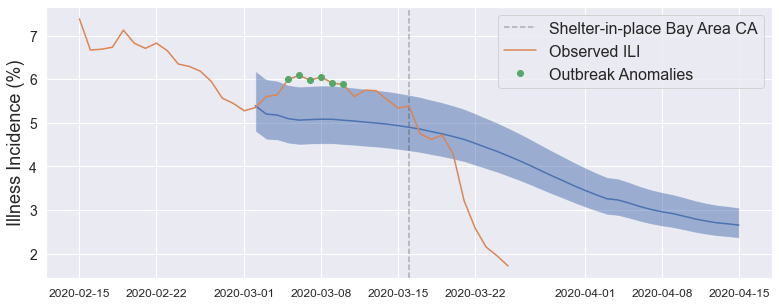

In [9]:
sub_sc = sc100[(sc100.ds >= '2020-02-15') &
               (sc100.ds <= '2020-04-15')].copy()
sub_sc.sort_values('ds', inplace=True)

plt.figure(figsize=(13, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--',
            alpha=0.3, label='Shelter-in-place Bay Area CA')
plt.fill_between(sub_sc.ds, sub_sc['97.5%'], sub_sc['2.5%'], alpha=0.5)
plt.plot(sub_sc.ds, sub_sc['50%'], label='')
plt.plot(sub_sc.ds, sub_sc.percent_ill, label='Observed ILI')
plt.plot(sub_sc.ds, sub_sc.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')
plt.ylabel('Illness Incidence (%)', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig('FigS2.png', dpi=300)